In [1]:
import gym
import numpy as np
import cv2


class PytorchWrapper(gym.Wrapper):
    # adopted from atari wrappers
    # https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py
    # changes returns from atari gym object
    # resize and greyscale, stack k frames and clip rewards

    def __init__(self, env, k, size=(84, 84), add_done=False):
        super(PytorchWrapper, self).__init__(env)
        self.add_done = add_done
        self.frame_stack = 0
        self.k = k
        self.last_life_count = 0
        self.score = 0
        self.size = size

    def reset(self):
        self.score = 0
        self.last_life_count = 0

        ob = self.env.reset()
        ob = self.preprocess_frame(ob)

        # stack k times the reset ob
        self.frame_stack = np.stack([ob for i in range(self.k)])

        return self.frame_stack

    def step(self, action):
        reward = 0
        done = False
        additional_done = False

        # do k frame skips
        frames = []
        for i in range(self.k):

            ob, r, d, info = self.env.step(action)

            # if agents loses a life, insert additional done
            if self.add_done:
                if info['ale.lives'] < self.last_life_count:
                    additional_done = True
                self.last_life_count = info['ale.lives']

            ob = self.preprocess_frame(ob)
            frames.append(ob)

            reward += r

            if d:
                done = True
                break

        # shift observation to pytorch compatible input
        self.prepare_frame_stack(frames)

        # add score to info
        self.score += reward
        if done:
            info["score"] = self.score

        # clip the reward (-1, 1)
        if reward > 0:
            reward = 1
        elif reward == 0:
            reward = 0
        else:
            reward = -1

        return self.frame_stack, reward, done, info, additional_done

    def prepare_frame_stack(self, frames):

        num_frames = len(frames)

        # stack frames
        if num_frames == self.k:
            self.frame_stack = np.stack(frames)
        elif num_frames > self.k:
            self.frame_stack = np.array(frames[-self.k::])
        else:

            # change dims to pytorch compatible format
            self.frame_stack[0: self.k - num_frames] = self.frame_stack[num_frames::]
            # add frames to stack
            self.frame_stack[self.k - num_frames::] = np.array(frames)

    def preprocess_frame(self, ob):
        # resize and greyscale

        ob = cv2.cvtColor(ob, cv2.COLOR_BGR2GRAY)
        ob = cv2.resize(ob, dsize=self.size)

        return ob


In [2]:
import random
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class DQNNetwork(nn.Module):
    """
    Convolution network taken from nature DQN paper 4x84x84 input.
    """

    def __init__(self, input_channels, out_actions):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.linear1 = nn.Linear(64 * 7 * 7, 512)
        self.linear2 = nn.Linear(512, out_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 7 * 7)  # flatten
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


last 100 reward mean(20): -0.6
last 100 reward mean(40): 1.0
last 100 reward mean(60): 2.0
last 100 reward mean(80): 2.4
last 100 reward mean(100): 3.1
---SAVING MODEL (steps: 200000)----
last 100 reward mean(120): 4.1
last 100 reward mean(140): 4.8
last 100 reward mean(160): 5.2
last 100 reward mean(180): 5.8
last 100 reward mean(200): 5.6
last 100 reward mean(220): 5.6
---SAVING MODEL (steps: 400000)----
last 100 reward mean(240): 5.6
last 100 reward mean(260): 5.5
last 100 reward mean(280): 6.2
last 100 reward mean(300): 7.2
last 100 reward mean(320): 8.9
---SAVING MODEL (steps: 600000)----
last 100 reward mean(340): 10.0
last 100 reward mean(360): 11.6
last 100 reward mean(380): 12.1
last 100 reward mean(400): 13.2
last 100 reward mean(420): 14.0
last 100 reward mean(440): 14.8
---SAVING MODEL (steps: 800000)----
last 100 reward mean(460): 16.3
last 100 reward mean(480): 17.8
last 100 reward mean(500): 18.6
last 100 reward mean(520): 19.6
last 100 reward mean(540): 21.6
last 100 re

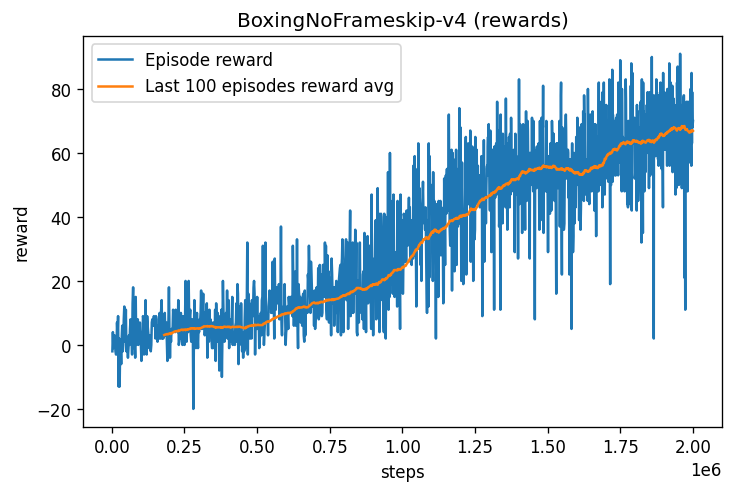

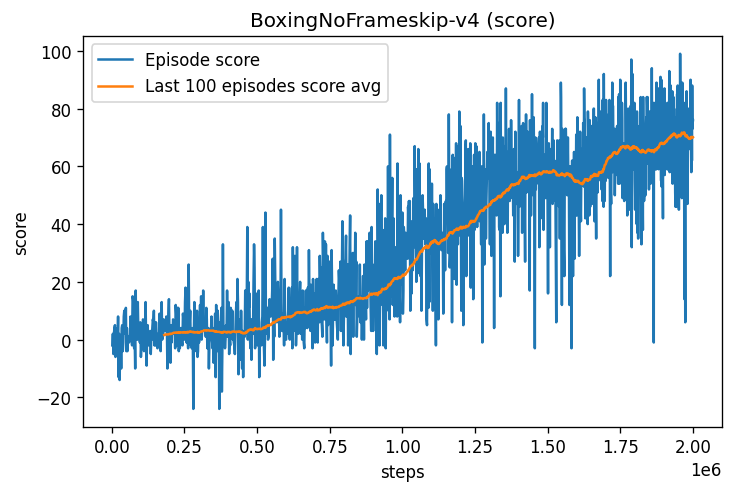

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim as optim

device = "cuda"

# ENV = MsPacmanNoFrameskip-v4
ENV_NAME = 'BoxingNoFrameskip-v4'

DATA_FILE_NAME = ENV_NAME + '.csv'

STEPS = 2000001  # steps to run
REPLAY_MEMORY_SIZE = 100000  # memory size
MIN_STEPS_UPDATE = 5000  # to first populate replay memory with data
TARGET_NET_UPDATE = 5000  # frequency of net params update
STEPS_SAVE = 200000  # frequency of model dump
UPDATE_EVERY_N_STEPS = 4  # no need to train weights each env step

BATCH_SIZE = 32
LEARNING_RATE = 0.0001
# hyper parameter of q learning
# closer to 1 = more previous steps are taken into account more
# closer to 0 means only very recent steps are given weight
GAMMA = 0.99
# epsilon greedy
START_EPS = 1
END_EPS = 0.05
EPS_INT = START_EPS - END_EPS
END_EPS_LIMIT_STEP = 1000000

INPUT_CHANNELS = 4  # input to conv nn based on DQN paper (4 channels - 4 stacked 84x84 frames)

replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE)

env = gym.make(ENV_NAME)
# env = gym.wrappers.Monitor(env, './video/', video_callable=lambda episode_id: episode_id % 10 == 0, force=True)
# atari wrapper clips image, greyscale, framestack, clip reward and add score to info
env = PytorchWrapper(env, 4, add_done=True)

N_ACTIONS = env.action_space.n  # taken from env

policy_net = DQNNetwork(INPUT_CHANNELS, N_ACTIONS).to(device)
target_net = DQNNetwork(INPUT_CHANNELS, N_ACTIONS).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
huber_loss = torch.nn.SmoothL1Loss()

image = env.reset()
image = torch.tensor(image)

episode_rewards = [0.0]
episode_scores = [0.0]

# create data file/remove old data
with open(DATA_FILE_NAME, 'w') as file:
    pass

for s in range(STEPS):
    epsilon = np.maximum(END_EPS, START_EPS - (EPS_INT * s / END_EPS_LIMIT_STEP))
    actions = policy_net(image.unsqueeze(0).to(device).float() / 255.)

    p = random.random()
    if epsilon < p:
        action = torch.argmax(actions)
        action = action.detach().cpu().numpy()
    else:
        action = env.action_space.sample()

    next_image, reward, done, info, additional_done = env.step(action)

    episode_rewards[-1] += reward
    if done:
        episode_scores[-1] += info["score"]
        next_image = env.reset()

        mean_reward_last_100 = round(np.mean(episode_rewards[-101:-1]), 1)
        mean_score_last_100 = round(np.mean(episode_scores[-101:-1]), 1)

        #  write training data to file
        with open(DATA_FILE_NAME, 'a') as file:
            if len(episode_rewards) > 100:
                file.write(str(s) + "," + str(episode_rewards[-1]) + ","
                           + str(mean_reward_last_100) + "," + str(episode_scores[-1])
                           + "," + str(mean_score_last_100))
                file.write('\n')
            else:
                file.write(str(s) + "," + str(episode_rewards[-1]) + ","
                           + "," + str(episode_scores[-1])
                           + ",")
                file.write('\n')

        if len(episode_rewards) % 20 == 0:
            print("last 100 reward mean(" + str(len(episode_rewards)) + "): " + str(mean_reward_last_100))
            # print("last 100 score mean (" + str(len(episode_scores)) + "): " + str(mean_score_last_100))
        episode_rewards.append(0.0)
        episode_scores.append(0.0)

    next_image = torch.tensor(next_image)

    done = done or additional_done
    replay_memory.push(image, action, next_image, reward, int(not done))
    image = next_image

    if s > MIN_STEPS_UPDATE:

        # give more time to steps to repopulate replay memory with new data
        if s % UPDATE_EVERY_N_STEPS == 0:

            optimizer.zero_grad()

            # get and process data from replay memory
            transitions = replay_memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*transitions))

            state_batch = (torch.stack(batch.state).to(device).float()) / 255.
            action_batch = np.stack(batch.action)
            next_state_batch = (torch.stack(batch.next_state).to(device).float()) / 255.
            reward_batch = torch.from_numpy(np.asarray(batch.reward)).to(device)
            done_batch = torch.from_numpy(np.asarray(batch.done)).to(device)
            # print(reward_batch)
            # print(done_batch)

            #  Qs from policy net
            # state_Q = policy_net(state_batch)
            # next_state_Q = policy_net(next_state_batch)
            Qs = policy_net(torch.cat([state_batch, next_state_batch]))
            state_Q, next_state_Q = torch.split(Qs, BATCH_SIZE, dim=0)

            # select value from batch with given action value from action_batch
            state_Q = state_Q[range(BATCH_SIZE), action_batch]

            # select max per batch from next state as targets
            next_state_Q_max = torch.max(next_state_Q, 1)[1].detach()
            # target Qs from target net
            target_Q = target_net(next_state_batch)[range(BATCH_SIZE), next_state_Q_max].detach()

            target = reward_batch + GAMMA * target_Q * done_batch

            # print(state_Q)
            # print(target)

            del state_batch
            del next_state_batch
            # loss
            loss = huber_loss(state_Q.float(), target.float())
            loss.backward()
            optimizer.step()

            # updating target net from policy net
            if s % TARGET_NET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

            # saving model for tests
            if s % STEPS_SAVE == 0:
                print("---SAVING MODEL (steps: " + str(s) + ")----")
                torch.save(target_net, ENV_NAME + str(s) + ".pt")

# PLOT DATA:

fig, ax = plt.subplots(constrained_layout=True)
data = np.genfromtxt(DATA_FILE_NAME, delimiter=",", names=["x", "y", "z", "a", "b"])
ax.plot(data['x'], data['y'], label='Episode reward')
ax.plot(data['x'], data['z'], label='Last 100 episodes reward avg')
ax.set_xlabel('steps')
ax.set_ylabel('reward')
ax.legend()
plt.title(ENV_NAME + ' (rewards)')
fig.set_dpi(120)

fig.savefig("rewards")

fig2, ax2 = plt.subplots(constrained_layout=True)
ax2.plot(data['x'], data['a'], label='Episode score')
ax2.plot(data['x'], data['b'], label='Last 100 episodes score avg')
ax2.set_xlabel('steps')
ax2.set_ylabel('score')
ax2.legend()
plt.title(ENV_NAME + ' (score)')
fig2.set_dpi(120)
fig2.savefig("scores")
